In [1]:
import xarray as xr
import numpy as np
import dask
import os
import re
import glob
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def file_filter(list_files: list[str], must_contain: str) -> list[str]:
    return [file for file in list_files if re.search(must_contain,file)]

In [3]:
data_dir = "/scratch/opodriscoll/data/ERA5/*.zarr"
year = "2020"
list_files = glob.glob(str(data_dir))

files = file_filter(list_files, must_contain=year)
files

['/scratch/opodriscoll/data/ERA5/2020_10m_u_component_of_wind.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_significant_height_of_combined_wind_waves_and_swell.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_mean_wave_period.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_ocean_surface_stress_equivalent_10m_neutral_wind_direction.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_2m_dewpoint_temperature.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_mean_surface_downward_short_wave_radiation_flux.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_peak_wave_period.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_mean_surface_latent_heat_flux.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_10m_v_component_of_wind.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_mean_surface_sensible_heat_flux.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_boundary_layer_heighttotal_precipitation.zarr',
 '/scratch/opodriscoll/data/ERA5/2020_ocean_surface_stress_equivalent_10m_neutral_wind_speed.zarr',
 '/scratch/opodriscoll/data/ERA5/2020

In [4]:
ds = xr.open_mfdataset(files, engine="zarr")

## 1.0 Generate some random points to test querrying .zarr

In [5]:
n_time = ds.sizes['valid_time']
n_lat = ds.sizes['latitude']
n_lon = ds.sizes['longitude']

# Generate random indices to sample from
n_samples = 100000
random_time_idx = np.random.randint(0, n_time, n_samples)
random_lat_idx = np.random.randint(0, n_lat, n_samples)
random_lon_idx = np.random.randint(0, n_lon, n_samples)

# Get the corresponding coordinate values for the random samples
random_valid_times = ds['valid_time'].values[random_time_idx]
random_latitudes = ds['latitude'].values[random_lat_idx]
random_longitudes = ds['longitude'].values[random_lon_idx]

In [6]:
%%timeit -n 1
t = ds.sel(
    valid_time=xr.DataArray(random_valid_times, dims='points'),
    latitude=xr.DataArray(random_latitudes, dims='points'),
    longitude=xr.DataArray(random_longitudes, dims='points'),
    method='nearest'
).compute()
t

2min 39s ± 50.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
t = ds.sel(
    valid_time=xr.DataArray(random_valid_times, dims='points'),
    latitude=xr.DataArray(random_latitudes, dims='points'),
    longitude=xr.DataArray(random_longitudes, dims='points'),
    method='nearest'
).compute()

## 2.0 Apply COARE

In [13]:
from pycoare import coare_35
from CMOD_analysis.arden_buck import arden_buck
from CMOD_analysis.era5_processing import Kelvin2Celcius, period2PhaseSpeed, Pascal2mBar

In [8]:
?coare_35

Init signature:
coare_35(
    u: 'ArrayLike',
    t: 'ArrayLike' = [10.0],
    rh: 'ArrayLike' = [75.0],
    zu: 'ArrayLike' = [10.0],
    zt: 'ArrayLike' = [10.0],
    zq: 'ArrayLike' = [10.0],
    zrf: 'ArrayLike' = [10.0],
    us: 'ArrayLike' = [0.0],
    ts: 'ArrayLike' = [10.0],
    p: 'ArrayLike' = [1015.0],
    lat: 'ArrayLike' = [45.0],
    zi: 'ArrayLike' = [600.0],
    rs: 'ArrayLike' = [150.0],
    rl: 'ArrayLike' = [370.0],
    rain: 'ArrayLike' = None,
    cp: 'ArrayLike' = None,
    sigH: 'ArrayLike' = None,
    jcool: 'int' = 1.0,
    nits: 'int' = 10,
) -> 'None'
Docstring:     
:param u: ocean surface wind speed (m/s) at height zu
:type u: ArrayLike
:param t: bulk air temperature (degC) at height zt
:type t: ArrayLike, optional
:param rh: relative humidity (%) at height zq
:type rh: ArrayLike, optional
:param zu: wind sensor height (m)
:type zu: ArrayLike, optional
:param zt: bulk air temperature sensor height (m)
:type zt: ArrayLike, optional
:param zq: relative humid

In [14]:
c = coare_35(
    u=t["wind"],
    t=Kelvin2Celcius(t["t2m"]),
    rh=arden_buck(Kelvin2Celcius(t["d2m"]), Kelvin2Celcius(t["t2m"]), p=Pascal2mBar(t["msl"])),
    zu=10,
    zt=2,
    zq=2, 
    zrf=10, 
    us=0, 
    ts=Kelvin2Celcius(t["sst"]),
    p=Pascal2mBar(t["msl"]),
    lat=t["latitude"],
    zi=t["blh"],
    rs=t["msdwswrf"],
    rl=t["msdwlwrf"],
    # rain: 
    cp=period2PhaseSpeed(t["pp1d"]),
    sigH=t["swh"],
    jcool = 1.0,
    nits = 10,
)

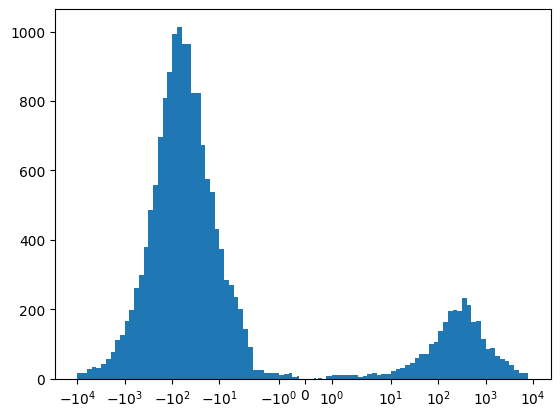

In [15]:
delta = 0.1
L = c.stability_parameters.obukL

bins = np.concatenate((-10**np.arange(4, -4, -delta) , 10**np.arange(-4, 4, delta)))
plt.hist(L, bins = bins)
plt.gca().set_xscale("symlog")